In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# Step 1: Load the Data
# Replace 'path_to_train_file.csv' and 'path_to_test_file.csv' with the actual file paths
train_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/NSL_KDD_Train.csv')
test_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/NSL_KDD_Test.csv')

In [3]:

# Step 2: Separate Features and Labels
# Assuming the last column is the label and the rest are features
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# Step 3: Align Columns to Keep Only the Common Columns
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Step 4: Encode Categorical Features with Consistent Categories
categorical_columns = X_train.select_dtypes(include=['object']).columns

for col in categorical_columns:
    combined_categories = pd.concat([X_train[col], X_test[col]], axis=0).astype("category").cat.categories
    X_train[col] = pd.Categorical(X_train[col], categories=combined_categories)
    X_test[col] = pd.Categorical(X_test[col], categories=combined_categories)
    
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Step 5: Scale Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Encode Labels with Combined Categories
# Combine `y_train` and `y_test` to fit LabelEncoder on all possible labels
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Print the unique classes in the label
print("Label classes:", label_encoder.classes_)


Label classes: ['apache2' 'back' 'buffer_overflow' 'ftp_write' 'guess_passwd'
 'httptunnel' 'imap' 'ipsweep' 'land' 'loadmodule' 'mailbomb' 'mscan'
 'multihop' 'named' 'neptune' 'nmap' 'normal' 'perl' 'phf' 'pod'
 'portsweep' 'processtable' 'ps' 'rootkit' 'saint' 'satan' 'sendmail'
 'smurf' 'snmpgetattack' 'snmpguess' 'spy' 'sqlattack' 'teardrop'
 'udpstorm' 'warezclient' 'warezmaster' 'worm' 'xlock' 'xsnoop' 'xterm']


In [4]:

# Step 7: Train the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 500],      # Number of trees in the forest
    'max_depth': [10, 20, 30, None],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples required to be at a leaf node
    'class_weight': ['balanced', 'balanced_subsample']  # Handling imbalance
}
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=20,                 # Number of parameter combinations to try
    cv=3,                      # Number of cross-validation folds
    verbose=2,                 # Level of logging
    random_state=42,
    n_jobs=-1                  # Use all available cores
)

# Run the hyperparameter search on the training data
rf_random.fit(X_train_scaled, y_train_encoded)

# Retrieve the best model after search
best_rf_model = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced'}


In [5]:

# Step 7: Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    class_weight='balanced',
   random_state=42)
rf_model.fit(X_train_scaled, y_train_encoded)
print("Model training complete.")

# Step 8: Evaluate the Model
# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Decode predictions back to original labels for readability
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels,zero_division=1))

Model training complete.
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
                 precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       1.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       1.00      0.00      0.00       141
           land       0.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          name

In [6]:
import numpy as np
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import BoundaryAttack
from art.attacks.evasion import HopSkipJump

/opt/anaconda3/lib/python3.11/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [7]:
# Step 1: Wrap the trained Random Forest model using ART's SklearnClassifier
classifier = SklearnClassifier(model=rf_model)
from sklearn.feature_selection import SelectKBest, f_classif

# Select top K features (adjust K based on dataset size and desired reduction)
selector = SelectKBest(f_classif, k=28)
X_train_reduced = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_reduced = selector.transform(X_test_scaled)

# Use X_test_reduced and X_train_reduced for further steps instead of the full dataset
X_attack = X_test_reduced[:20]

# Step 2: Select a subset of the test set for the attacks to keep the computation manageable
num_samples =20
y_attack = y_test_encoded[:20]

# Step 3: Perform the Boundary Attack
print("\n--- Boundary Attack ---")
boundary_attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=50, delta=0.005)
X_adv_boundary = boundary_attack.generate(x=X_attack)
X_adv_boundary = np.nan_to_num(X_adv_boundary, nan=0.0, posinf=1.0, neginf=-1.0)
# Step 4: Generate adversarial samples for Boundary Attack



# Predict on adversarial samples generated by Boundary Attack
y_pred_adv_boundary = classifier.predict(X_adv_boundary)

y_pred_decoded_boundary = label_encoder.inverse_transform(np.argmax(y_pred_adv_boundary, axis=1))
y_true_decoded_boundary = label_encoder.inverse_transform(y_attack)

# Evaluate and print Boundary Attack results
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_boundary, y_pred_decoded_boundary))
print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_boundary, y_pred_decoded_boundary, zero_division=1))



--- Boundary Attack ---


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Boundary attack:   0%|          | 0/20 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Confusion Matrix after Boundary Attack:
[[ 0  2  0  0  0  0  0]
 [ 0  2  0  0  0  0  0]
 [ 0  3  0  0  1  1  0]
 [ 0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]]

Classification Report after Boundary Attack:
              precision    recall  f1-score   support

guess_passwd       1.00      0.00      0.00         2
       mscan       0.11      1.00      0.20         2
     neptune       1.00      0.00      0.00         5
      normal       1.00      0.00      0.00        10
        perl       0.00      1.00      0.00         0
   portsweep       0.00      1.00      0.00         0
       saint       1.00      0.00      0.00         1

    accuracy                           0.10        20
   macro avg       0.59      0.43      0.03        20
weighted avg       0.91      0.10      0.02        20



In [8]:
# Step 1: Wrap the trained Random Forest model
classifier = SklearnClassifier(model=rf_model)

# Step 2: Select a subset of the test set for the attack (e.g., 10 samples to limit computation)
num_samples = 100
X_attack = X_test_scaled[:num_samples]
y_attack = y_test_encoded[:num_samples]

# Step 3: Configure and perform the HopSkipJump Attack
print("\n--- HopSkipJump Attack ---")
hop_skip_jump_attack = HopSkipJump(
    classifier=classifier,
    targeted=False,
    max_iter=50,        # You may adjust this based on computational resources
    max_eval=10000,
    init_eval=10
)

X_adv_hsj = hop_skip_jump_attack.generate(x=X_attack)

# Step 4: Predict on the adversarial samples generated by HopSkipJump Attack
y_pred_adv_hsj = classifier.predict(X_adv_hsj)
y_pred_decoded_hsj = label_encoder.inverse_transform(np.argmax(y_pred_adv_hsj, axis=1))
y_true_decoded_hsj = label_encoder.inverse_transform(y_attack)

# Step 5: Evaluate and print the HopSkipJump Attack results
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_hsj, y_pred_decoded_hsj))
print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_hsj, y_pred_decoded_hsj, zero_division=1))


--- HopSkipJump Attack ---


HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

Confusion Matrix after HopSkipJump Attack:
[[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 7: Train the SVM Model
# Initialize the SVM model with desired parameters (e.g., kernel='linear' or 'rbf', C=1.0)
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the model on the scaled training data
svm_model.fit(X_train_scaled, y_train_encoded)

# Step 8: Make Predictions
# Use the trained model to make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
import numpy as np

# Get unique classes in the test set
unique_labels = np.unique(np.concatenate([y_test_encoded, y_pred]))

# Filter the target names to match only the unique classes
filtered_target_names = [label_encoder.classes_[i] for i in unique_labels]

# Print the classification report with the filtered target names
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, labels=unique_labels, target_names=filtered_target_names))


Accuracy: 0.42359047154327284
Classification Report:
                  precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.05      0.00      0.01      4656
           nmap       0.00      0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Step 1: Wrap the trained Random Forest model using ART's SklearnClassifier
classifier = SklearnClassifier(model=svm_model)
from sklearn.feature_selection import SelectKBest, f_classif

# Select top K features (adjust K based on dataset size and desired reduction)
selector = SelectKBest(f_classif, k=28)
X_train_reduced = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_reduced = selector.transform(X_test_scaled)

# Use X_test_reduced and X_train_reduced for further steps instead of the full dataset
X_attack = X_test_reduced[:50]

# Step 2: Select a subset of the test set for the attacks to keep the computation manageable
num_samples =50
y_attack = y_test_encoded[:50]

# Step 3: Perform the Boundary Attack
print("\n--- Boundary Attack ---")
boundary_attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=100, delta=0.01)
X_adv_boundary = boundary_attack.generate(x=X_attack)
X_adv_boundary = np.nan_to_num(X_adv_boundary, nan=0.0, posinf=1.0, neginf=-1.0)
# Step 4: Generate adversarial samples for Boundary Attack



# Predict on adversarial samples generated by Boundary Attack
y_pred_adv_boundary = classifier.predict(X_adv_boundary)

y_pred_decoded_boundary = label_encoder.inverse_transform(np.argmax(y_pred_adv_boundary, axis=1))
y_true_decoded_boundary = label_encoder.inverse_transform(y_attack)

# Evaluate and print Boundary Attack results
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_boundary, y_pred_decoded_boundary))
print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_boundary, y_pred_decoded_boundary, zero_division=1))



--- Boundary Attack ---


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Boundary attack:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Confusion Matrix after Boundary Attack:
[[ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]]

Classification Report after Boundary Attack:
                 precision    recall  f1-score   support

        apache2       1.00      0.00      0.00         1
           back       1.00      0.00      0.00         1
buffer_overflow       1.00      0.00      0.00         1
   guess_passwd       1.00      0.00      0.00         2
          mscan       1.00      0.00      0.00         5
        neptune       1.00      0.00      0.00        10
         normal       0.54      1.00      0.70        27
          saint       1.00      0.00      0.00         1
          satan       1.00      0.00      0.00         1
          sm

In [11]:
# Step 1: Wrap the trained Random Forest model
classifier = SklearnClassifier(model=svm_model)

# Step 2: Select a subset of the test set for the attack (e.g., 10 samples to limit computation)
num_samples = 100
X_attack = X_test_scaled[:num_samples]
y_attack = y_test_encoded[:num_samples]

# Step 3: Configure and perform the HopSkipJump Attack
print("\n--- HopSkipJump Attack ---")
hop_skip_jump_attack = HopSkipJump(
    classifier=classifier,
    targeted=False,
    max_iter=100,        # You may adjust this based on computational resources
    max_eval=10000,
    init_eval=10
)

X_adv_hsj = hop_skip_jump_attack.generate(x=X_attack)

# Step 4: Predict on the adversarial samples generated by HopSkipJump Attack
y_pred_adv_hsj = classifier.predict(X_adv_hsj)
y_pred_decoded_hsj = label_encoder.inverse_transform(np.argmax(y_pred_adv_hsj, axis=1))
y_true_decoded_hsj = label_encoder.inverse_transform(y_attack)

# Step 5: Evaluate and print the HopSkipJump Attack results
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_hsj, y_pred_decoded_hsj))
print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_hsj, y_pred_decoded_hsj, zero_division=1))


--- HopSkipJump Attack ---


HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

Confusion Matrix after HopSkipJump Attack:
[[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 51  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]]

Classification Report after HopSkipJu

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Create XGBoost DMatrix for training and testing
# XGBoost requires data to be converted into DMatrix format for efficient training
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_encoded)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_encoded)

# Step 2: Set up parameters for the XGBoost model
params = {
    'objective': 'multi:softmax',  # for multi-class classification
    'num_class': len(label_encoder.classes_),  # number of classes
    'eval_metric': 'mlogloss',  # evaluation metric
    'max_depth': 6,  # maximum depth of the tree
    'eta': 0.1,  # learning rate
    'subsample': 0.8,  # fraction of samples to use for each tree
    'colsample_bytree': 0.8,  # fraction of features to use for each tree
    'seed': 42  # for reproducibility
}

# Step 3: Train the model
num_round = 100  # number of training rounds
bst = xgb.train(params, dtrain, num_round)

# Step 4: Make predictions
y_pred = bst.predict(dtest)

import numpy as np
# Ensure predictions are integers within the valid range
y_pred = y_pred.astype(int)  # Ensure predictions are integer values

# Filter `unique_labels` to contain only valid indices within the range of `label_encoder.classes_`
unique_labels = np.unique(np.concatenate([y_test_encoded, y_pred]))
unique_labels = unique_labels[unique_labels < len(label_encoder.classes_)]

# Get filtered target names based on `unique_labels`
filtered_target_names = [label_encoder.classes_[i] for i in unique_labels]

# Print the classification report with the filtered target names
from sklearn.metrics import classification_report

# Step 5: Evaluate the Model
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, labels=unique_labels, target_names=filtered_target_names))


Accuracy: 0.34649336822960564
Classification Report:
                  precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       0.00      0.00      0.00         3
   guess_passwd       0.00      0.00      0.00      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       0.00      0.00      0.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.69      0.32      0.44      4656
           nmap       0.00      0

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from art.attacks.evasion import BoundaryAttack
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming `classifier` is the ART-wrapped XGBoost model and `label_encoder` is already defined

# Step 1: Select a subset of the test set for the Boundary Attack
num_samples = 10  # Adjust this as needed
X_attack = X_test_scaled[:num_samples]
y_attack = y_test_encoded[:num_samples]  # Use the already encoded labels for compatibility

# Step 2: Initialize the Boundary Attack
boundary_attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=190)


# Step 3: Generate Adversarial Samples
X_adv = boundary_attack.generate(x=X_attack)

# Handle any NaN or Inf values in the adversarial samples
X_adv = np.nan_to_num(X_adv, nan=0.0, posinf=1.0, neginf=-1.0)

# Step 4: Predict on Adversarial Samples
y_pred_adv = classifier.predict(X_adv)
y_pred_labels_adv = np.argmax(y_pred_adv, axis=1)

# Decode predictions and true labels to original categories for interpretability
y_pred_decoded_adv = label_encoder.inverse_transform(y_pred_labels_adv)
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 5: Display Results
print("\n--- Evaluation After Boundary Attack ---")
print("Confusion Matrix after Boundary Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after Boundary Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))



Boundary attack:   0%|          | 0/10 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/190 [00:00<?, ?it/s]


--- Evaluation After Boundary Attack ---
Confusion Matrix after Boundary Attack:
[[0 0 0 2 0]
 [0 0 0 2 0]
 [0 0 0 1 0]
 [0 0 0 4 0]
 [0 0 0 1 0]]

Classification Report after Boundary Attack:
              precision    recall  f1-score   support

guess_passwd       1.00      0.00      0.00         2
       mscan       1.00      0.00      0.00         2
     neptune       1.00      0.00      0.00         1
      normal       0.40      1.00      0.57         4
       saint       1.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.88      0.20      0.11        10
weighted avg       0.76      0.40      0.23        10



In [33]:
from art.attacks.evasion import HopSkipJump
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming `classifier` is the ART-wrapped XGBoost model and `label_encoder` is already defined

# Step 1: Select a subset of the test set for the HopSkipJump Attack
num_samples = 10  # Adjust this as needed
X_attack = X_test_scaled[:num_samples]
y_attack = y_test_encoded[:num_samples]  # Use the encoded labels

# Step 2: Initialize the HopSkipJump Attack
hop_skip_jump_attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=50, max_eval=1000, init_eval=10)

# Step 3: Generate Adversarial Samples
X_adv = hop_skip_jump_attack.generate(x=X_attack)

# Handle any NaN or Inf values in the adversarial samples
X_adv = np.nan_to_num(X_adv, nan=0.0, posinf=1.0, neginf=-1.0)

# Step 4: Predict on Adversarial Samples
y_pred_adv = classifier.predict(X_adv)
y_pred_labels_adv = np.argmax(y_pred_adv, axis=1)

# Decode predictions and true labels to original categories for interpretability
y_pred_decoded_adv = label_encoder.inverse_transform(y_pred_labels_adv)
y_true_decoded_adv = label_encoder.inverse_transform(y_attack)

# Step 5: Display Results
print("\n--- Evaluation After HopSkipJump Attack ---")
print("Confusion Matrix after HopSkipJump Attack:")
print(confusion_matrix(y_true_decoded_adv, y_pred_decoded_adv))

print("\nClassification Report after HopSkipJump Attack:")
print(classification_report(y_true_decoded_adv, y_pred_decoded_adv, zero_division=1))


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]


--- Evaluation After HopSkipJump Attack ---
Confusion Matrix after HopSkipJump Attack:
[[0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 1 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]

Classification Report after HopSkipJump Attack:
              precision    recall  f1-score   support

guess_passwd       1.00      0.00      0.00         2
       mscan       1.00      0.00      0.00         2
     neptune       1.00      0.00      0.00         1
      normal       0.44      1.00      0.62         4
   portsweep       0.00      1.00      0.00         0
       saint       1.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.74      0.33      0.10        10
weighted avg       0.78      0.40      0.25        10



In [37]:
import shap
import matplotlib.pyplot as plt
# Define explainers
rf_explainer = shap.TreeExplainer(rf_model)       # Random Forest
xgb_explainer = shap.TreeExplainer(bst)     # XGBoost
svm_explainer = shap.KernelExplainer(svm_model.predict, shap.sample(X_test_scaled, 100))  # SVM with sample data for KernelExplainer


In [39]:
shap_values_rf_clean = rf_explainer.shap_values(X_test_scaled)

In [43]:
shap_values_rf_boundary = rf_explainer.shap_values(X_adv_boundary)

In [45]:
shap_values_rf_hopskipjump = rf_explainer.shap_values(X_adv_hsj)

In [47]:
shap_values_xgb_clean = xgb_explainer.shap_values(X_test_scaled)

In [49]:
shap_values_xgb_boundary = xgb_explainer.shap_values(X_adv)

In [51]:
shap_values_xgb_hopskipjump = xgb_explainer.shap_values(X_adv)

In [53]:
X_test_sample = shap.sample(X_test_scaled, 10)  # Adjust 1000 to your needs
shap_values_svm_clean = svm_explainer.shap_values(X_test_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
X_adv_sample = shap.sample(X_adv, 10)  # Adjust 1000 to your needs
shap_values_svm_boundary = svm_explainer.shap_values(X_adv_sample)

In [66]:
X_adv_hopskipjump_sample = shap.sample(X_adv_hsj, 10)
shap_values_svm_hopskipjump = svm_explainer.shap_values(X_adv_hopskipjump_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [71]:
X_adv_sample = shap.sample(X_adv_boundary, 10)  # Adjust 1000 to your needs
shap_values_svm_boundary = svm_explainer.shap_values(X_adv_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
# Function to plot SHAP summary plots
def plot_shap_summary(shap_values, data, title):
    plt.figure()
    shap.summary_plot(shap_values, data, plot_type="bar", show=False)
    plt.title(title)
    plt.show()

Final shape of SHAP values: (22543, 28)
Final shape of data: (22543, 28)


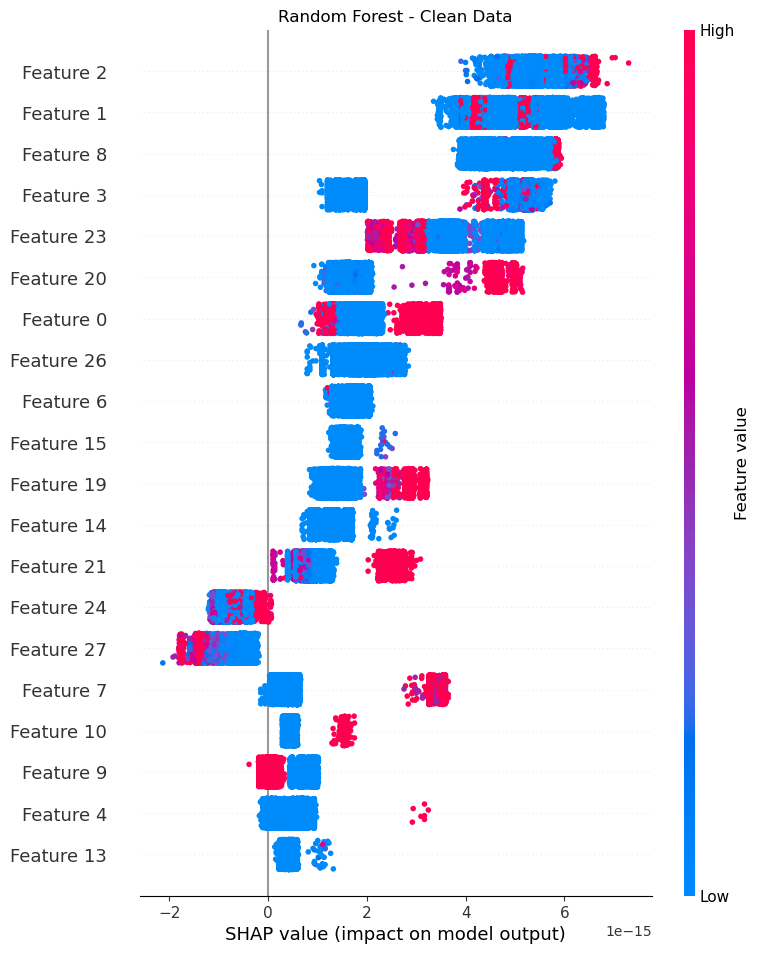

Final shape of SHAP values: (10, 28)
Final shape of data: (10, 28)


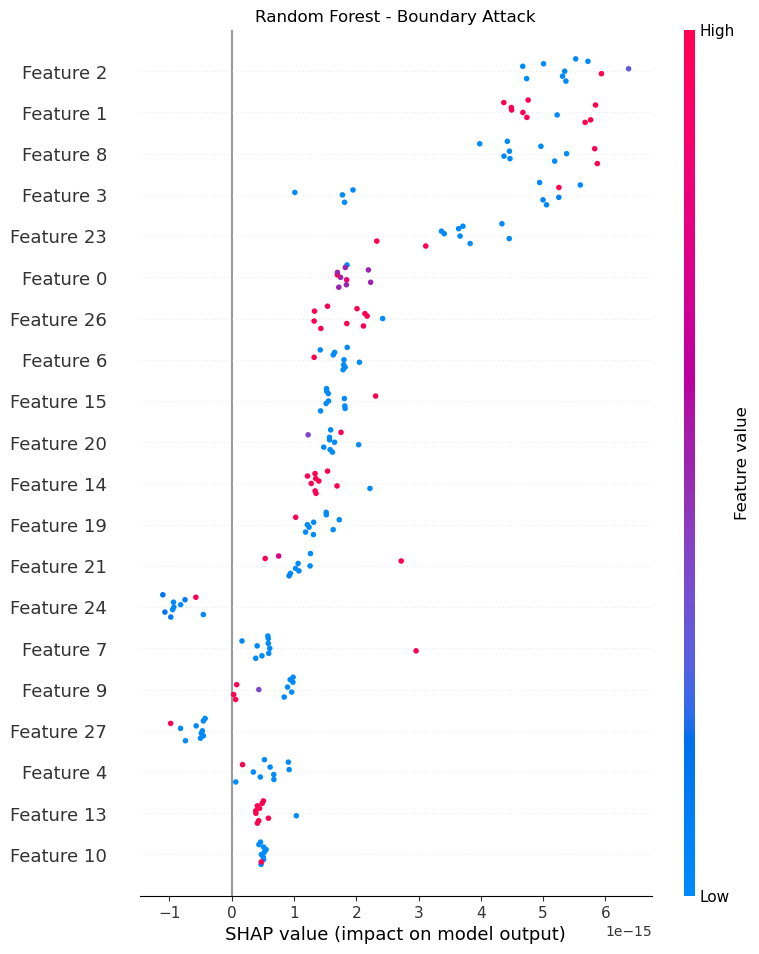

Final shape of SHAP values: (100, 28)
Final shape of data: (100, 28)


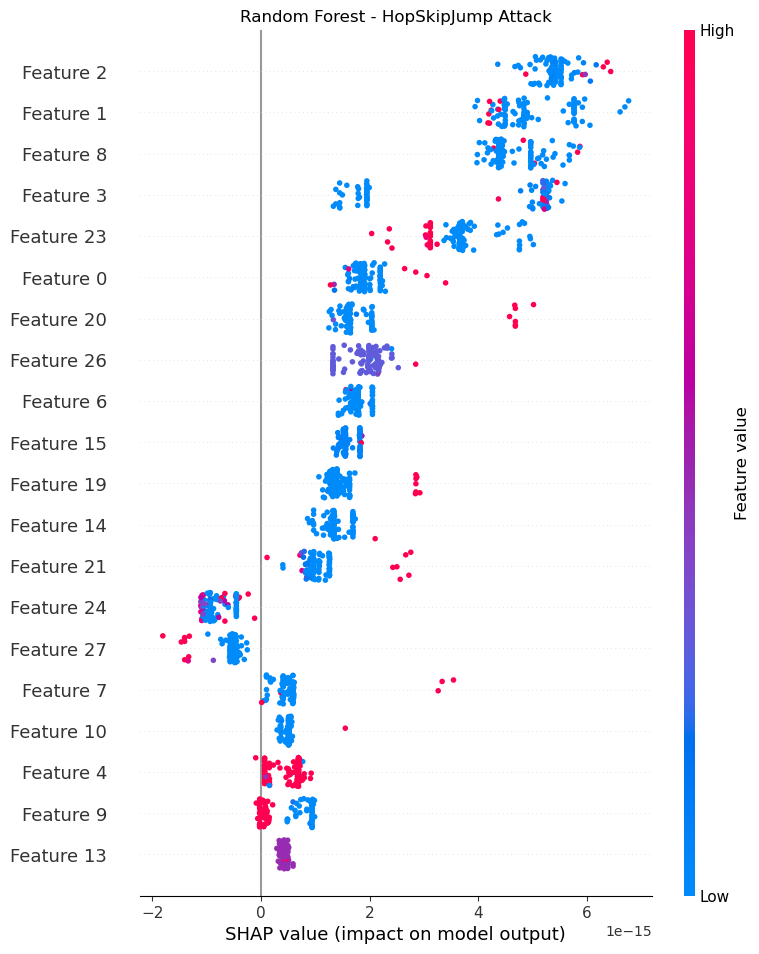

In [112]:
import matplotlib.pyplot as plt
import shap
import numpy as np

def plot_shap_summary(shap_values, data, title):
    # Step 1: Handle extra class dimension by averaging over it if present
    if shap_values.ndim == 3 and shap_values.shape[2] > 1:
        shap_values = shap_values.mean(axis=-1)
    
    # Step 2: Ensure row count alignment
    if shap_values.shape[0] != data.shape[0]:
        if shap_values.shape[0] < data.shape[0]:
            shap_values = np.tile(shap_values, (data.shape[0] // shap_values.shape[0] + 1, 1))[:data.shape[0]]
        else:
            shap_values = shap_values[:data.shape[0]]
    
    # Step 3: Column alignment: Limit to minimum feature count
    min_features = min(shap_values.shape[1], data.shape[1])
    shap_values = shap_values[:, :min_features]
    data = data[:, :min_features]

    # Confirm final shapes for debugging
    print("Final shape of SHAP values:", shap_values.shape)
    print("Final shape of data:", data.shape)

    # Plot summary as a dot plot
    plt.figure()
    shap.summary_plot(shap_values, data, plot_type="dot", show=False)
    plt.title(title)
    plt.show()

# Random Forest SHAP summary plots
plot_shap_summary(shap_values_rf_clean, X_test_scaled, "Random Forest - Clean Data")
plot_shap_summary(shap_values_rf_boundary, X_adv, "Random Forest - Boundary Attack")
plot_shap_summary(shap_values_rf_hopskipjump, X_adv_hsj, "Random Forest - HopSkipJump Attack")

Final shape of SHAP values: (22543, 28)
Final shape of data: (22543, 28)


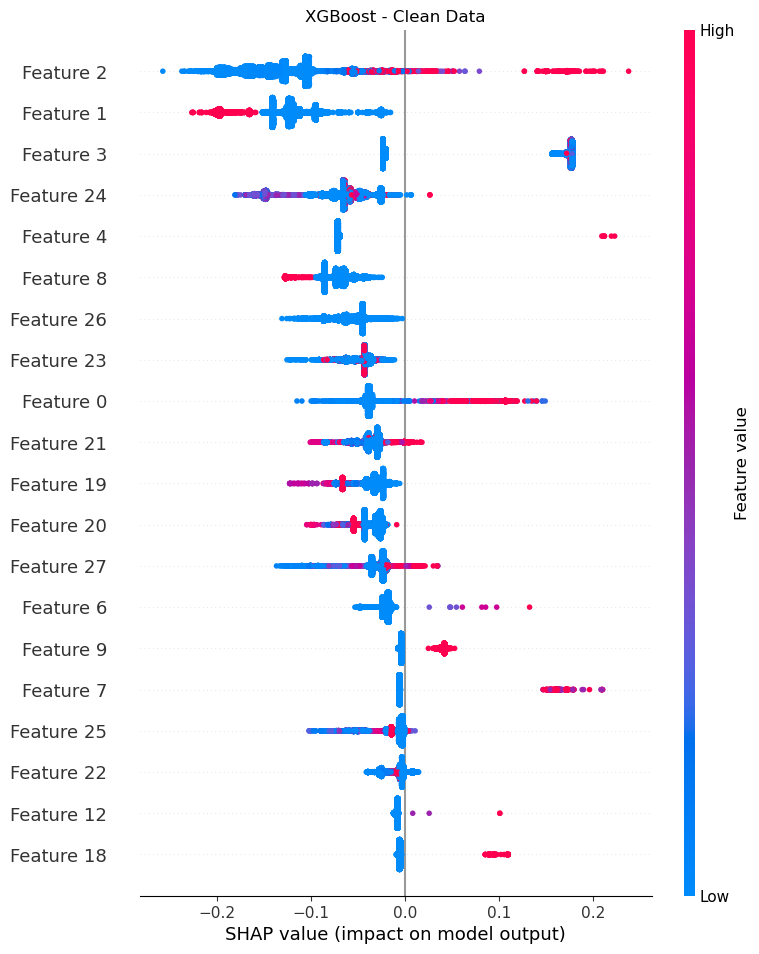

Final shape of SHAP values: (10, 28)
Final shape of data: (10, 28)


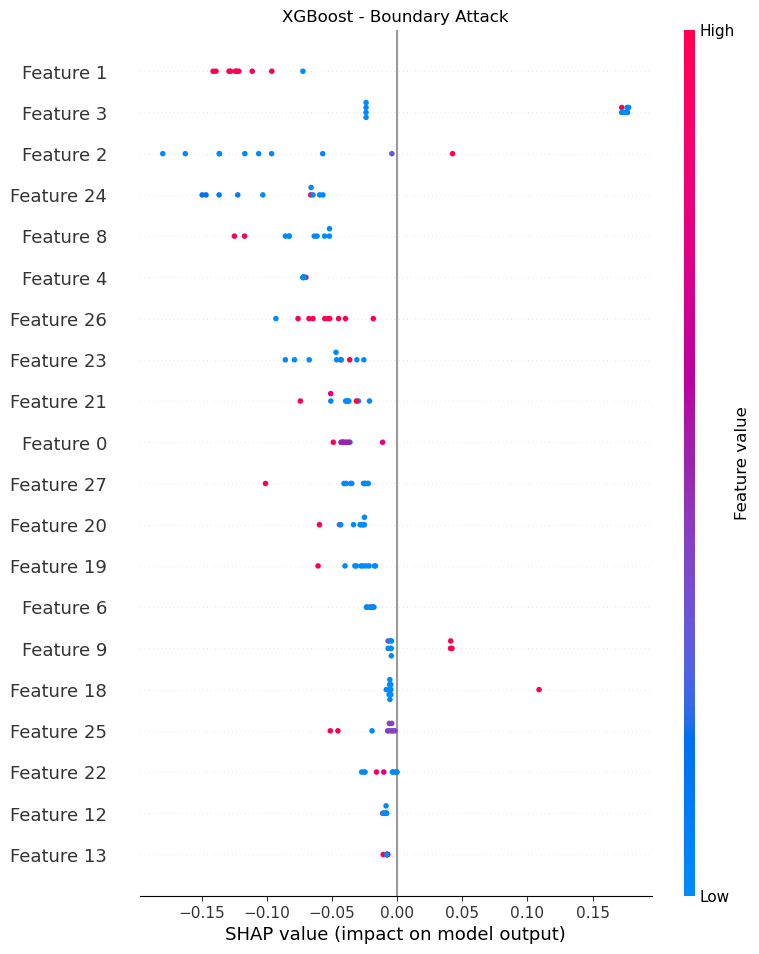

Final shape of SHAP values: (100, 28)
Final shape of data: (100, 28)


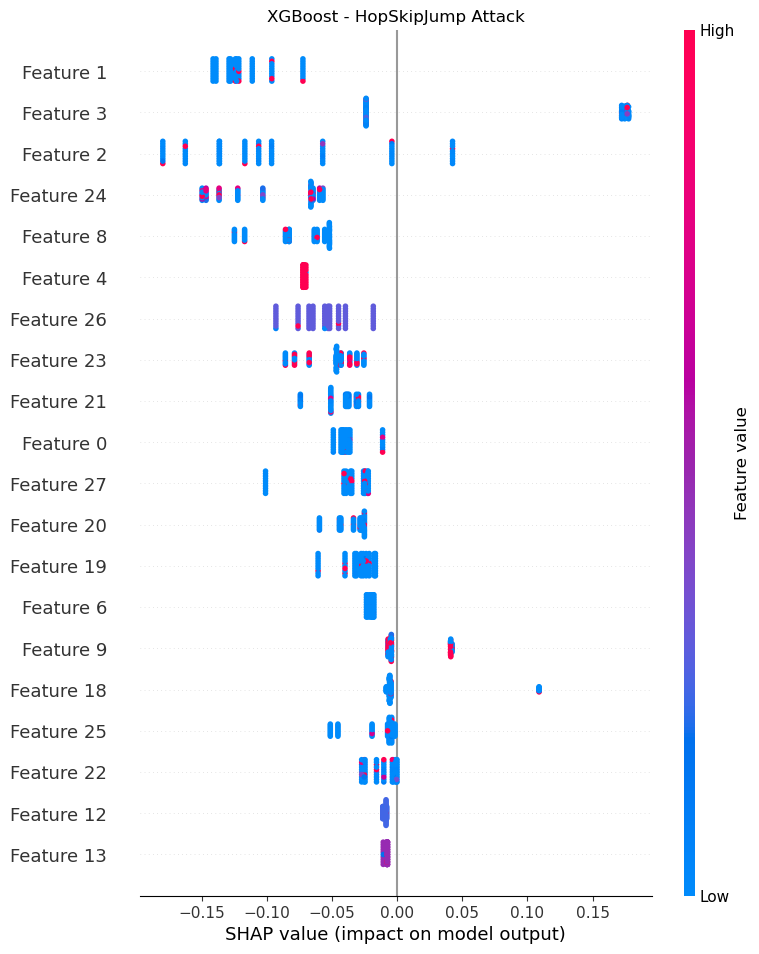

In [104]:
import matplotlib.pyplot as plt
import shap
import numpy as np

def plot_shap_summary(shap_values, data, title):
    # Step 1: Handle extra class dimension by averaging over it if present
    if shap_values.ndim == 3 and shap_values.shape[2] > 1:
        shap_values = shap_values.mean(axis=-1)
    
    # Step 2: Ensure row count alignment
    if shap_values.shape[0] != data.shape[0]:
        if shap_values.shape[0] < data.shape[0]:
            shap_values = np.tile(shap_values, (data.shape[0] // shap_values.shape[0] + 1, 1))[:data.shape[0]]
        else:
            shap_values = shap_values[:data.shape[0]]
    
    # Step 3: Column alignment: Limit to minimum feature count
    min_features = min(shap_values.shape[1], data.shape[1])
    shap_values = shap_values[:, :min_features]
    data = data[:, :min_features]

    # Confirm final shapes for debugging
    print("Final shape of SHAP values:", shap_values.shape)
    print("Final shape of data:", data.shape)

    # Plot summary as a dot plot
    plt.figure()
    shap.summary_plot(shap_values, data, plot_type="dot", show=False)
    plt.title(title)
    plt.show()

# Example usage with Random Forest or XGBoost SHAP summary plots
plot_shap_summary(shap_values_xgb_clean, X_test_scaled, "XGBoost - Clean Data")
plot_shap_summary(shap_values_xgb_boundary, X_adv, "XGBoost - Boundary Attack")
plot_shap_summary(shap_values_xgb_hopskipjump, X_adv_hsj, "XGBoost - HopSkipJump Attack")


Final shape of SHAP values: (22543, 28)
Final shape of data: (22543, 28)


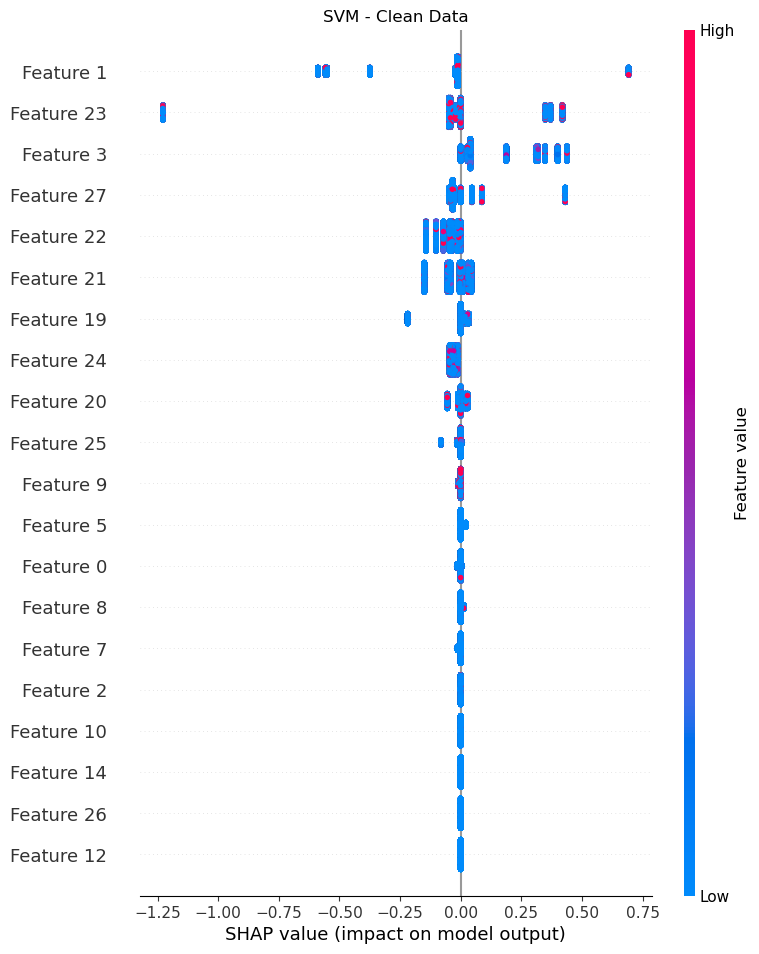

Final shape of SHAP values: (50, 28)
Final shape of data: (50, 28)


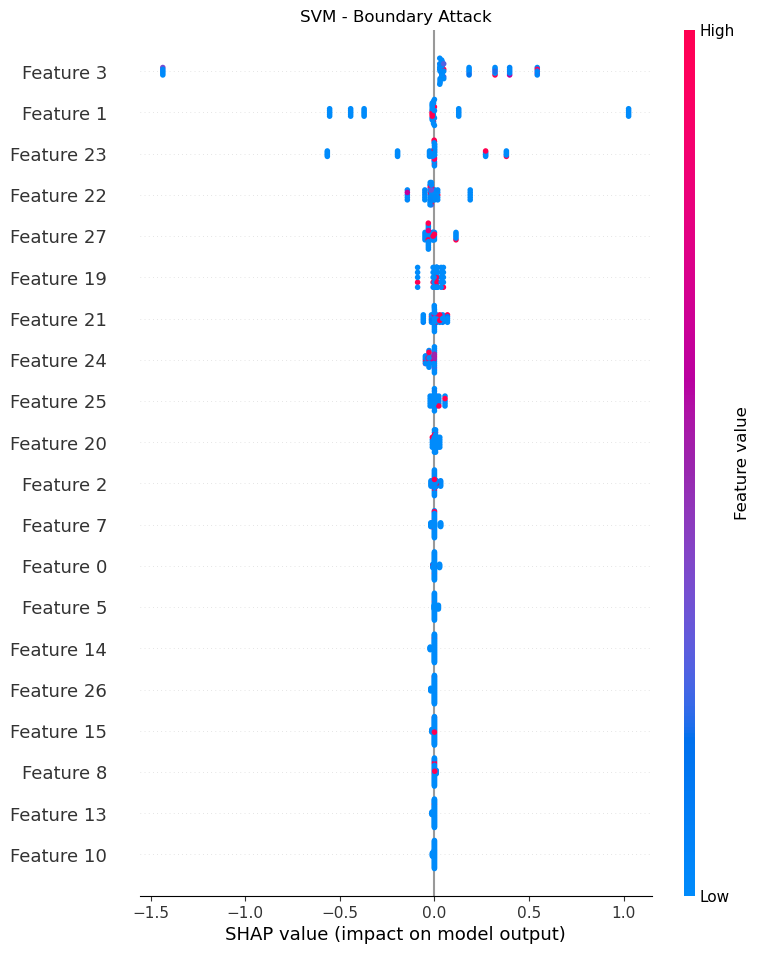

Final shape of SHAP values: (100, 28)
Final shape of data: (100, 28)


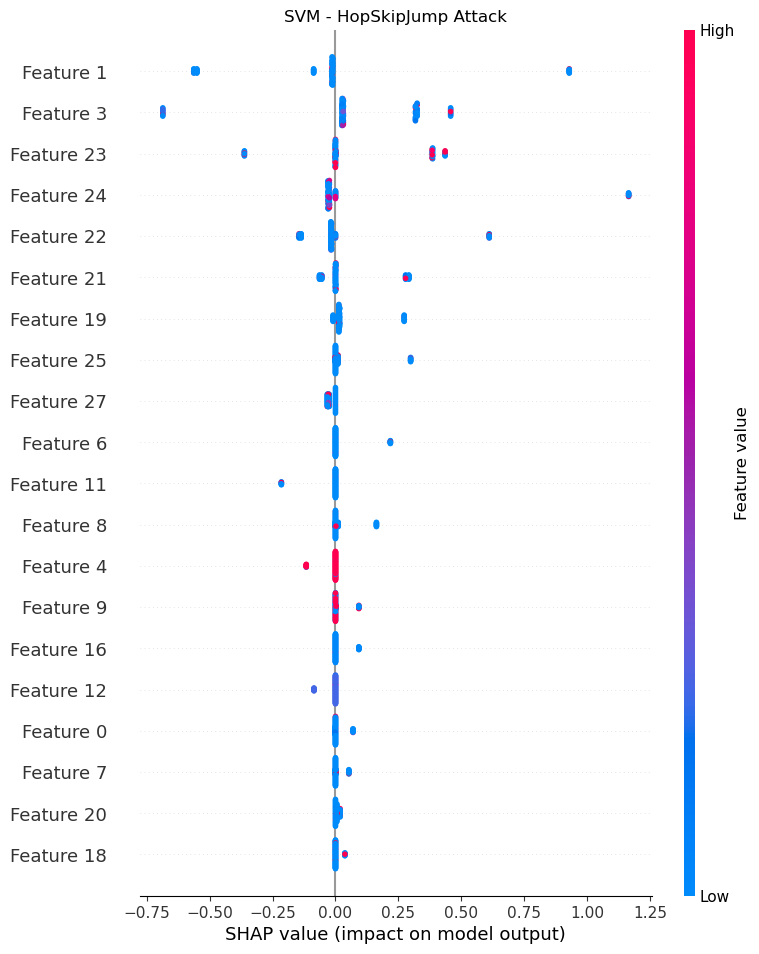

In [114]:
def plot_shap_summary(shap_values, data, title):
    # Step 1: Handle extra class dimension by averaging over it if present
    if shap_values.ndim == 3 and shap_values.shape[2] > 1:
        shap_values = shap_values.mean(axis=-1)
    
    # Step 2: Ensure row count alignment
    if shap_values.shape[0] != data.shape[0]:
        if shap_values.shape[0] < data.shape[0]:
            shap_values = np.tile(shap_values, (data.shape[0] // shap_values.shape[0] + 1, 1))[:data.shape[0]]
        else:
            shap_values = shap_values[:data.shape[0]]
    
    # Step 3: Column alignment: Limit to minimum feature count
    min_features = min(shap_values.shape[1], data.shape[1])
    shap_values = shap_values[:, :min_features]
    data = data[:, :min_features]

    # Confirm final shapes for debugging
    print("Final shape of SHAP values:", shap_values.shape)
    print("Final shape of data:", data.shape)

    # Plot summary as a dot plot
    plt.figure()
    shap.summary_plot(shap_values, data, plot_type="dot", show=False)
    plt.title(title)
    plt.show()
plot_shap_summary(shap_values_svm_clean, X_test_scaled, "SVM - Clean Data")
plot_shap_summary(shap_values_svm_boundary, X_adv_boundary, "SVM - Boundary Attack")
plot_shap_summary(shap_values_svm_hopskipjump, X_adv_hsj, "SVM - HopSkipJump Attack")